In [1]:
r""" Visual Prompt Encoder training (validation) code """

import argparse
import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from common import utils
from common.evaluation import Evaluator
from common.logger import AverageMeter, Logger
from data.dataset import FSSDataset
from model.VRP_encoder import VRP_encoder
from SAM2pred import SAM_pred


def eval(args, epoch, model, sam_model, dataloader):
    r"""Train VRP_encoder model"""

    utils.fix_randseed(args.seed)
    model.module.eval()
    average_meter = AverageMeter(dataloader.dataset)

    for idx, batch in enumerate(dataloader):

        batch = utils.to_cuda(batch)
        protos, _ = model(
            args.condition,
            batch["query_img"],
            batch["support_imgs"].squeeze(1),
            batch["support_masks"].squeeze(1),
            False,
        )

        low_masks, pred_mask = sam_model(
            batch["query_img"], batch["query_name"], protos
        )
        logit_mask = low_masks

        pred_mask = torch.sigmoid(logit_mask) > 0.5
        pred_mask = pred_mask.float()

        loss = model.module.compute_objective(logit_mask, batch["query_mask"])
        print(pred_mask.shape, batch.keys())

        area_inter, area_union = Evaluator.classify_prediction(
            pred_mask.squeeze(1), batch
        )
        average_meter.update(
            area_inter, area_union, batch["class_id"], loss.detach().clone()
        )
        average_meter.write_process(idx, len(dataloader), epoch, write_batch_idx=50)

    average_meter.write_result("Validation", epoch)
    avg_loss = utils.mean(average_meter.loss_buf)
    miou, fb_iou = average_meter.compute_iou()

    return avg_loss, miou, fb_iou



In [2]:
import sys
import os

# Set the environment variables for distributed training
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12345'
os.environ['WORLD_SIZE'] = '1'
os.environ['RANK'] = '0'

sys.argv = ['run',
    '--datapath', '../',
    '--logpath', 'test_gso',
    '--benchmark', 'gso',
    '--backbone', 'resnet50',
    '--fold', '1',
    '--condition', 'mask',
    '--num_query', '50',
    '--epochs', '50',
    '--lr', '1e-4',
    '--bsz', '1',
    '--local_rank', '0'
    '--nshot', '14'
]

# Arguments parsing
parser = argparse.ArgumentParser(
    description="Visual Prompt Encoder Pytorch Implementation"
)
parser.add_argument(
    "--datapath", type=str, default="/root/paddlejob/workspace/env_run/datsets/"
)
parser.add_argument(
    "--benchmark", type=str, default="coco", choices=["pascal", "coco", "fss", "linemod"]
)
parser.add_argument("--logpath", type=str, default="")
parser.add_argument(
    "--bsz", type=int, default=2
)  # batch size = num_gpu * bsz default num_gpu = 4
parser.add_argument("--lr", type=float, default=1e-4)
parser.add_argument("--weight_decay", type=float, default=1e-6)
parser.add_argument("--epochs", type=int, default=50)
parser.add_argument("--nworker", type=int, default=8)
parser.add_argument("--seed", type=int, default=321)
parser.add_argument("--fold", type=int, default=0, choices=[0, 1, 2, 3])
parser.add_argument(
    "--condition",
    type=str,
    default="mask",
    choices=["point", "scribble", "box", "mask"],
)
parser.add_argument(
    "--use_ignore",
    type=bool,
    default=True,
    help="Boundaries are not considered during pascal training",
)
parser.add_argument(
    "--local_rank",
    type=int,
    default=-1,
    help="number of cpu threads to use during batch generation",
)
parser.add_argument("--num_query", type=int, default=50)
parser.add_argument(
    "--backbone",
    type=str,
    default="resnet50",
    choices=["vgg16", "resnet50", "resnet101"],
)
parser.add_argument(
    "--nshot",
    type=int,
    default=14,
)
args = parser.parse_args()


In [3]:
!rm -r logs/linemod_eval1.log

In [4]:
# Distributed setting
local_rank = args.local_rank
print("local_rank: ", local_rank)
torch.cuda.set_device(local_rank)
device = torch.device("cuda", local_rank)

if utils.is_main_process():
    Logger.initialize(args, training=True)
utils.fix_randseed(args.seed)
# Model initialization
model = VRP_encoder(args, args.backbone, False)
if utils.is_main_process():
    Logger.log_params(model)



:=========== Few-shot Seg. with VRP-SAM ===========
|             datapath: ../Datasets_HSN/        
|            benchmark: pascal                  
|              logpath: linemod_eval1           
|                  bsz: 1                       
|                   lr: 0.0001                  
|         weight_decay: 1e-06                   
|               epochs: 50                      
|              nworker: 8                       
|                 seed: 321                     
|                 fold: 1                       
|            condition: mask                    
|           use_ignore: True                    
|           local_rank: 0                       
|            num_query: 50                      
|             backbone: resnet50                
:==================================================



local_rank:  0


Backbone # param.: 23685367
Learnable # param.: 1592064
Total # param.: 25277431


In [5]:
sam_model = SAM_pred()
sam_model.to(device)
model.to(device)
dist.init_process_group("nccl", rank=0, world_size=1)
model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
# Device setup
model = torch.nn.parallel.DistributedDataParallel(
    model,
    device_ids=[args.local_rank],
    output_device=args.local_rank,
    find_unused_parameters=True,
)

for param in model.module.layer0.parameters():
    param.requires_grad = False
for param in model.module.layer1.parameters():
    param.requires_grad = False
for param in model.module.layer2.parameters():
    param.requires_grad = False
for param in model.module.layer3.parameters():
    param.requires_grad = False
for param in model.module.layer4.parameters():
    param.requires_grad = False

Evaluator.initialize(args)


Added key: store_based_barrier_key:1 to store for rank: 0
Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 1 nodes.


In [6]:
model_path = "logs/pascal_f1/best_model.pt"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model loaded from {model_path}")
else:
    print(f"No saved model found at {model_path}")

Model loaded from logs/pascal_f1/best_model.pt


In [7]:

# Dataset initialization
FSSDataset.initialize(
    img_size=512, datapath=args.datapath, use_original_imgsize=False
)

dataloader_val = FSSDataset.build_dataloader(
    args.benchmark, args.bsz, args.nworker, args.fold, "val", shot=14
)


Total (val) images are : 445


In [8]:
for idx, batch in enumerate(dataloader_val):
    if idx == 0:
        break

In [44]:
batch["support_imgs"].shape, batch["support_masks"].shape

(torch.Size([1, 5, 3, 512, 512]), torch.Size([1, 5, 512, 512]))

In [25]:
epoch=0

utils.fix_randseed(args.seed)
model.module.eval()
average_meter = AverageMeter(dataloader_val.dataset)

for idx, batch in enumerate(dataloader_val):
    logit_mask_agg = 0

    batch = utils.to_cuda(batch)
    protos = model.module.forward_nshot(
        args.condition,
        batch["query_img"],
        batch["support_imgs"],
        batch["support_masks"],
        False,
        nshot=5
    )
    print(protos.shape)

    low_masks, pred_mask = sam_model(
        batch["query_img"], batch["query_name"], protos
    )
    logit_mask = low_masks

    pred_mask = torch.sigmoid(logit_mask) > 0.5
    pred_mask = pred_mask.float()

    logit_mask_agg += pred_mask.squeeze(1).clone()

    loss = model.module.compute_objective(logit_mask, batch["query_mask"])
    print(pred_mask.shape, batch.keys())


    area_inter, area_union = Evaluator.classify_prediction(
        pred_mask.squeeze(1), batch
    )
    average_meter.update(
        area_inter, area_union, batch["class_id"], loss.detach().clone()
    )
    average_meter.write_process(idx, len(dataloader_val), epoch, write_batch_idx=50)

    break

# average_meter.write_result("Validation", epoch)
# avg_loss = utils.mean(average_meter.loss_buf)
# miou, fb_iou = average_meter.compute_iou()

# return avg_loss, miou, fb_iou

[Epoch: 00] [Batch: 0001/1000] L: 1.67919  Avg L: 1.67919  mIoU:  0.00  |  FB-IoU: 40.36


torch.Size([1, 250, 256])
torch.Size([1, 1, 512, 512]) dict_keys(['query_img', 'query_mask', 'query_name', 'query_ignore_idx', 'org_query_imsize', 'support_imgs', 'support_masks', 'support_names', 'support_ignore_idxs', 'class_id'])


In [50]:
pred_mask.shape

torch.Size([1, 1, 512, 512])

In [17]:
logit_mask_agg, support_mask, logit_mask = model.module.predict_mask_nshot(args, batch, sam_model, nshot=5, input_point=None)
logit_mask_agg.shape, support_mask.shape, logit_mask.shape

(torch.Size([1, 512, 512]),
 torch.Size([1, 512, 512]),
 torch.Size([1, 1, 512, 512]))

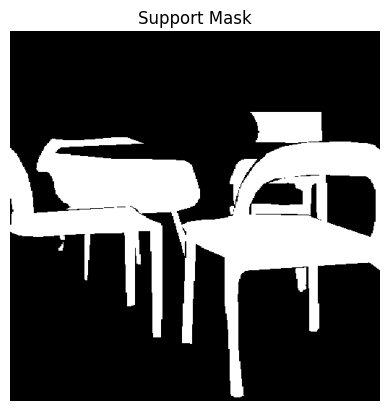

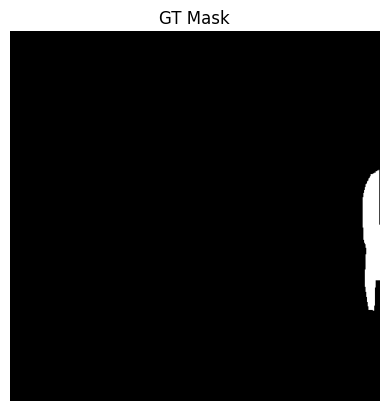

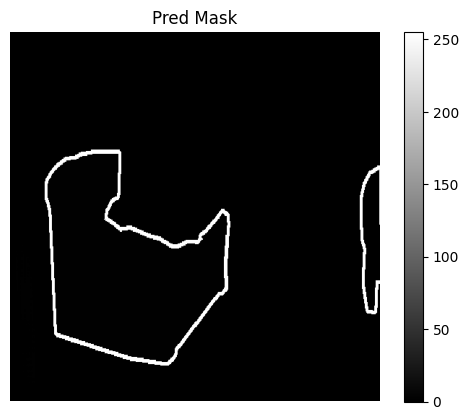

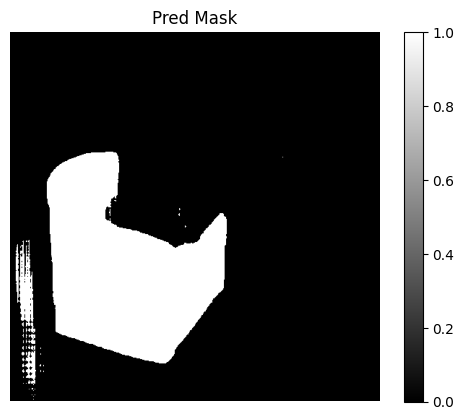

In [26]:
import matplotlib.pyplot as plt
# import numpy as np

index = 0

# Plotting the binary mask
plt.imshow(batch['support_masks'][:, 0][index].cpu().numpy(), cmap='gray')  # Use 'gray' to plot a binary mask
plt.title("Support Mask")
plt.axis('off')  # Optional: to hide axis
plt.show()

# Plotting the binary mask
plt.imshow(batch['query_mask'][index].cpu().numpy(), cmap='gray')  # Use 'gray' to plot a binary mask
plt.title("GT Mask")
plt.axis('off')  # Optional: to hide axis
plt.show()

# Plotting the binary mask
plt.imshow(pred_mask.squeeze(1)[index].cpu().numpy(), cmap='gray')  # Use 'gray' to plot a binary mask
plt.title("Pred Mask")
plt.colorbar()
plt.axis('off')  # Optional: to hide axis
plt.show()

# Plotting the binary mask
plt.imshow(logit_mask_agg[index].cpu().numpy(), cmap='gray')  # Use 'gray' to plot a binary mask
plt.title("Pred Mask")
plt.colorbar()
plt.axis('off')  # Optional: to hide axis
plt.show()


In [13]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

# De-normalizing the image
def denormalize_image(image, mean=torch.tensor([0.485, 0.456, 0.406]), std=torch.tensor([0.229, 0.224, 0.225])):
    """
    Denormalizes the input image tensor using the given mean and std values.
    Args:
        image (Tensor): The normalized image tensor (C x H x W).
        mean (Tensor): The mean values used for normalization (C).
        std (Tensor): The std values used for normalization (C).
    Returns:
        Tensor: The de-normalized image tensor (C x H x W).
    """
    denormalized_image = image * std[:, None, None] + mean[:, None, None]

    # To visualize the de-normalized image, move it to a range [0, 1]
    # Clamp to make sure the values are in valid image range
    denormalized_image = denormalized_image.clamp(0, 1)

    # Convert to numpy and transpose from (C x H x W) to (H x W x C)
    denormalized_image = denormalized_image.permute(1, 2, 0).numpy()
    return denormalized_image

def plot_rgb_mask(rgb, mask, title="Plot", alpha=0.8):

    # Denormalize the image
    denorm_rgb = denormalize_image(rgb)

    # Plot the image
    plt.imshow(denorm_rgb)

    mask = mask.clamp(0, 1)

    plt.imshow(mask, alpha=mask*0.8)

    plt.title(title)
    plt.axis('off')
    plt.show()

In [25]:
index = 20
for idx, supbatch in enumerate(dataloader_val):
    if idx == index:
        # Now `batch` contains the data for index 10
        break
batch = utils.to_cuda(batch)
protos, _ = model(
    args.condition,
    batch["query_img"],
    supbatch["query_img"],
    supbatch["query_mask"],
    False,
)

low_masks, pred_mask = sam_model(
    batch["query_img"], batch["query_name"], protos
)
logit_mask = low_masks

pred_mask = torch.sigmoid(logit_mask) > 0.5
pred_mask = pred_mask.float()

loss = model.module.compute_objective(logit_mask, batch["query_mask"])
print(pred_mask.shape, batch.keys(), loss)

torch.Size([1, 1, 512, 512]) dict_keys(['query_img', 'query_mask', 'query_name', 'query_ignore_idx', 'org_query_imsize', 'support_imgs', 'support_masks', 'support_names', 'support_ignore_idxs', 'class_id']) tensor(1.2548, device='cuda:0', grad_fn=<AddBackward0>)


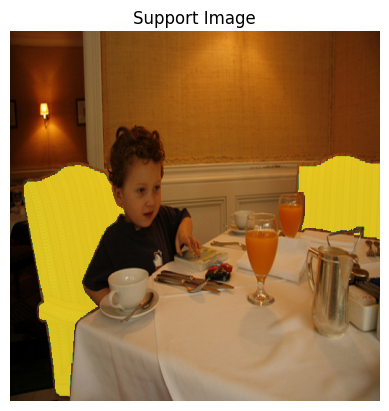

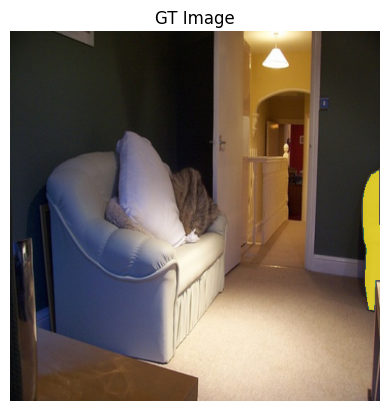

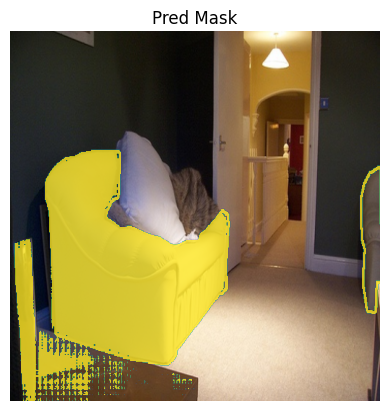

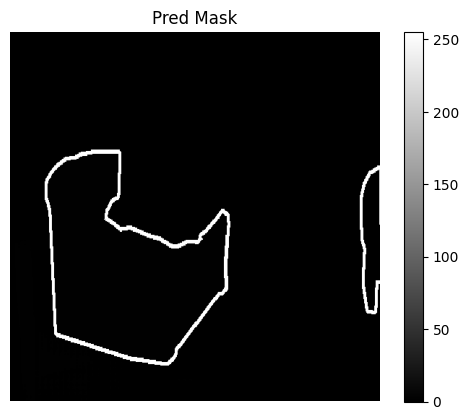

In [58]:
inbatch_index = 0

plot_rgb_mask(batch['support_imgs'][:,-1][inbatch_index].cpu(), batch['support_masks'][:,-1][inbatch_index].cpu(), title="Support Image")
plot_rgb_mask(batch['query_img'][inbatch_index].cpu(), batch['query_mask'][inbatch_index].cpu(), title="GT Image")
plot_rgb_mask(batch['query_img'][inbatch_index].cpu(), pred_mask[:,0][inbatch_index].cpu(), title="Pred Mask")

plt.imshow(pred_mask.squeeze(1)[inbatch_index].cpu().numpy(), cmap='gray')  # Use 'gray' to plot a binary mask
plt.title("Pred Mask")
plt.colorbar()
plt.axis('off')  # Optional: to hide axis
plt.show()
